from BiasStudy import datasets, predictionKit
from BiasStudy.datasets import FairFaceDataset
from BiasStudy.config.TrainingConfig import BiasStudyConfig
from BiasStudy.trainingKit import TrainingLogger
from BiasStudy.trainingKit.TrainingModel import BiasModel

In [79]:
import os
import sys
import platform
import numpy as np
import tensorflow as tf
import tensorflow.keras
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import Model
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-05-01 22:36:57.364200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 22:36:57.407860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 22:36:57.408129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Load Models

In [139]:
BASE_PATH_TO_WEIGHTS = "/notebooks/data/results/{0}_{1}/model_{0}conv_{1}kernel/model/model.h5"
BASE_PATH_TO_WEIGHTS_FLAT = "/notebooks/data/results_with_flat/{0}_{1}/model_{0}conv_{1}kernel_with_flat/model/model.h5"
PATH_TO_WEIGHTS = {
    "8_layers_3_kernel_no_flat": BASE_PATH_TO_WEIGHTS.format(8, 3),
    "8_layers_5_kernel_no_flat": BASE_PATH_TO_WEIGHTS.format(8, 5),
    "16_layers_3_kernel_no_flat": BASE_PATH_TO_WEIGHTS.format(16, 3),
    "16_layers_5_kernel_no_flat": BASE_PATH_TO_WEIGHTS.format(16, 5),
    "8_layers_3_kernel_with_flat": BASE_PATH_TO_WEIGHTS_FLAT.format(8, 3),
}

In [140]:
model_8layers_3kernel_with_flat = load_model(PATH_TO_WEIGHTS["8_layers_3_kernel_with_flat"])

In [148]:
# model_8layers_3kernel_with_flat.summary()

In [147]:
model_8layers_3kernel_all = load_model(PATH_TO_WEIGHTS["8_layers_3_kernel_no_flat"])

In [149]:
model_8layers_3kernel = Model(
    inputs = model_8layers_3kernel.input,
    outputs = model_8layers_3kernel.get_layer('flatten').output
)

In [150]:
model_8layers_3kernel.trainable = False
model_8layers_3kernel._name = "model_8layers_3kernel" #Due to a miss up in config

In [6]:
model_8layers_5kernel = load_model(PATH_TO_WEIGHTS["8_layers_5_kernel_no_flat"])

In [7]:
model_8layers_5kernel.trainable = False
model_8layers_5kernel._name = "model_8layers_5kernel"

In [8]:
model_16layers_3kernel = load_model(PATH_TO_WEIGHTS["16_layers_3_kernel_no_flat"])

In [9]:
model_16layers_3kernel.trainable = False
model_16layers_3kernel._name = "model_16layers_3kernel"

In [10]:
model_16layers_5kernel = load_model(PATH_TO_WEIGHTS["16_layers_5_kernel_no_flat"])

In [11]:
model_16layers_5kernel.trainable = False
model_16layers_5kernel._name = "model_16layers_5kernel"

# Understand Model Training

In [30]:
HISTORY_PATH_BASE = "/notebooks/data/results/{0}_{1}/model_{0}conv_{1}kernel/csv_logging/logsmodel_{0}conv_{1}kernel.csv"
PATH_TO_HISTORY = {
    "8_layers_3_kernel_no_flat": HISTORY_PATH_BASE.format(8, 3),
    "8_layers_5_kernel_no_flat": HISTORY_PATH_BASE.format(8, 5),
    "16_layers_3_kernel_no_flat": HISTORY_PATH_BASE.format(16, 3),
    "16_layers_5_kernel_no_flat": HISTORY_PATH_BASE.format(16, 5),
}

In [125]:
def read_csv_history(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df.epoch != 'epoch']
    df = df.reset_index(drop=True)
    df['index'] = df.index
    df = df.loc[df.groupby("epoch")["index"].idxmax()]
    df = df.astype(float)
    df = df.sort_values(by=['epoch'], ascending=True)
    df = df.reset_index(drop=True)
    return df.copy()

In [126]:
history_8layer_3kernel = read_csv_history(PATH_TO_HISTORY["8_layers_3_kernel_no_flat"])
history_8layer_5kernel = read_csv_history(PATH_TO_HISTORY["8_layers_5_kernel_no_flat"])
history_16layer_3kernel = read_csv_history(PATH_TO_HISTORY["16_layers_3_kernel_no_flat"])
history_16layer_5kernel = read_csv_history(PATH_TO_HISTORY["16_layers_5_kernel_no_flat"])

In [127]:
histories = {
    "8_layers_3_kernel": history_8layer_3kernel,
    "8_layers_5_kernel": history_8layer_5kernel,
    "16_layers_3_kernel": history_16layer_3kernel,
    "16_layers_5_kernel": history_16layer_5kernel,
}

In [129]:
def plot_all(histories_dict):
    num_plots = len(histories_dict)
    f, axs = plt.subplots(1, num_plots, sharey=True, figsize=(num_plots * 5,  5))
    for idx, (key, history) in enumerate(histories_dict.items()):
        axs[idx].plot(history.loss, label='training')
        axs[idx].plot(history.val_loss, label='validation')
        axs[idx].legend()
        axs[idx].set_title(key)
    plt.show()

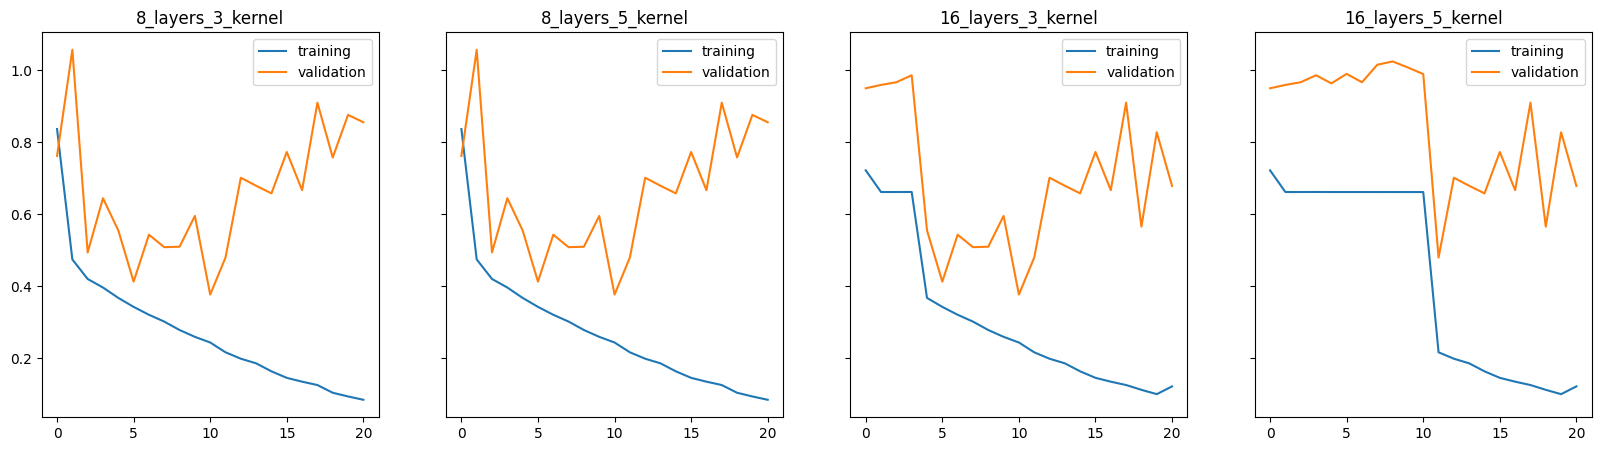

In [130]:
plot_all(histories)

# Load Dataset

In [12]:
IMAGE_DIR = "/notebooks/data/LFWA+/COMPILED/compiled_lfwa+"
BASE_DIR = "/notebooks/data/LFWA+/COMPILED"
ALL_PAIRS = "compiled_lfwa+_all_pairs.csv"

In [13]:
all_pairs =  pd.read_csv("{}/{}".format(BASE_DIR, ALL_PAIRS))

# Evaluation

## 8Layers - 3 Kernel Size

In [14]:
from BiasStudy.predictionKit import PredictionToolKit
from BiasStudy.predictionKit import PredictionPlotKit

Python Platform: Linux-5.19.0-45-generic-x86_64-with-glibc2.35
Tensor Flow Version: 2.12.1
Keras Version: 2.12.0

Python 3.8.19 (default, Apr  6 2024, 17:58:10) 
[GCC 11.4.0]


In [143]:
model_8layers_3kernel_wit_flat_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = model_8layers_3kernel_with_flat,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [144]:
print(model_8layers_3kernel_wit_flat_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 54.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.992067382827757 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.506131093935791 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.034482758620690 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.051724137931034 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 35.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.966609944862823 |
+-------

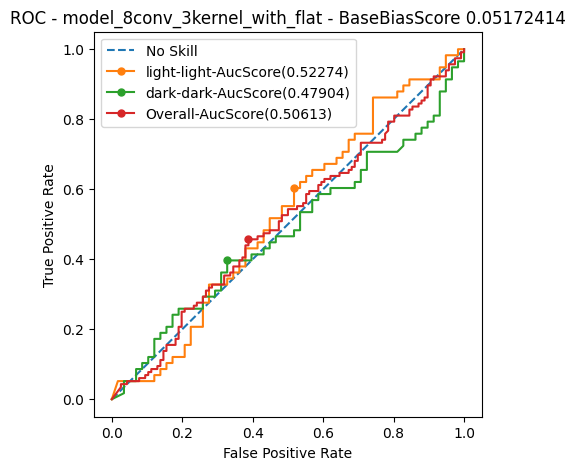

In [145]:
PredictionPlotKit.plot_roc(model_8layers_3kernel_wit_flat_result)

In [152]:
model_8layers_3kernel_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = model_8layers_3kernel,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [153]:
print(model_8layers_3kernel_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 38.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.136099695833411 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.622881985731272 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.086206896551724 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.034482758620690 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 18.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.136099695833411 |
+-------

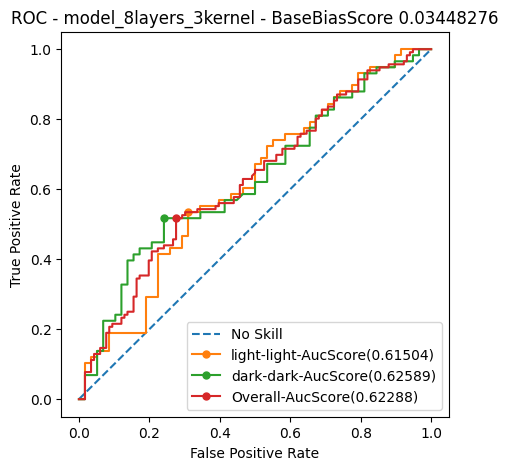

In [154]:
PredictionPlotKit.plot_roc(model_8layers_3kernel_result)

## 8Layers - 5 Kernel Size

In [18]:
model_8layers_5kernel_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = model_8layers_5kernel,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [19]:
print(model_8layers_5kernel_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 48.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.927987973476950 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.481755350772889 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.017241379310345 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 30.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.865288200477186 |
+-------

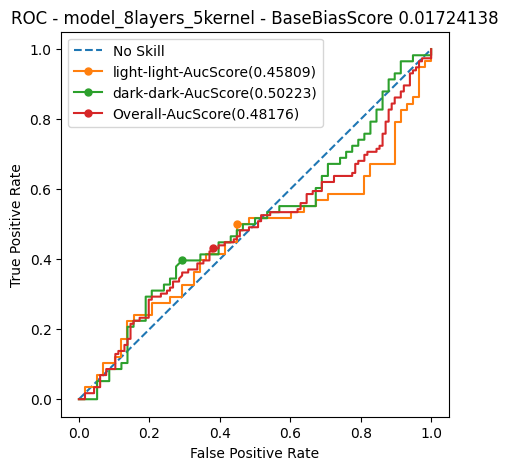

In [20]:
PredictionPlotKit.plot_roc(model_8layers_5kernel_result)

## 16Layers - 3 Kernel Size

In [21]:
model_16layers_3kernel_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = model_16layers_3kernel,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [22]:
print(model_16layers_3kernel_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 51.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.967973667107509 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.514974732461355 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.120689655172414 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.034482758620690 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 28.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.977383723700468 |
+-------

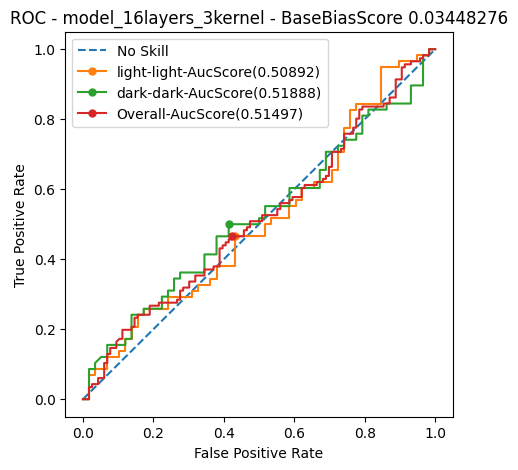

In [23]:
PredictionPlotKit.plot_roc(model_16layers_3kernel_result)

## 16Layers - 5Kernel Size

In [24]:
model_16layers_5kernel_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = model_16layers_5kernel,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [25]:
print(model_16layers_5kernel_result)

+-------------+------------------------+---------------------+
| Variation   | Metric Name            |               Value |
+=============+========================+=====================+
| OverAll     | Best Threshold IDX     |   0.000000000000000 |
+-------------+------------------------+---------------------+
| OverAll     | Best Threshold         | inf                 |
+-------------+------------------------+---------------------+
| OverAll     | AUC Score              |   0.500000000000000 |
+-------------+------------------------+---------------------+
| OverAll     | Bias At Best Threshold |   0.000000000000000 |
+-------------+------------------------+---------------------+
| OverAll     | Base Bias at 0.1 FPR   |   0.000000000000000 |
+-------------+------------------------+---------------------+
| light-light | Best Threshold IDX     |   0.000000000000000 |
+-------------+------------------------+---------------------+
| light-light | Best Threshold         | inf           

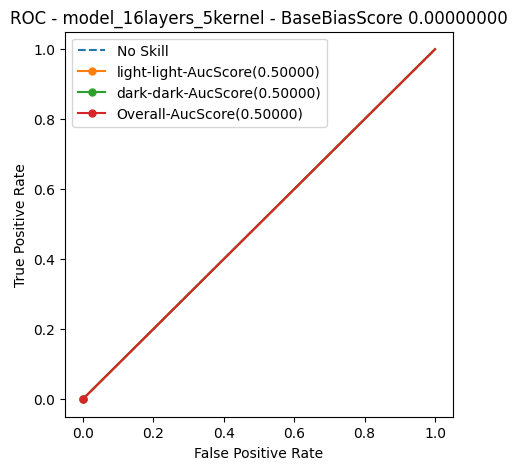

In [26]:
PredictionPlotKit.plot_roc(model_16layers_5kernel_result)

## ALL

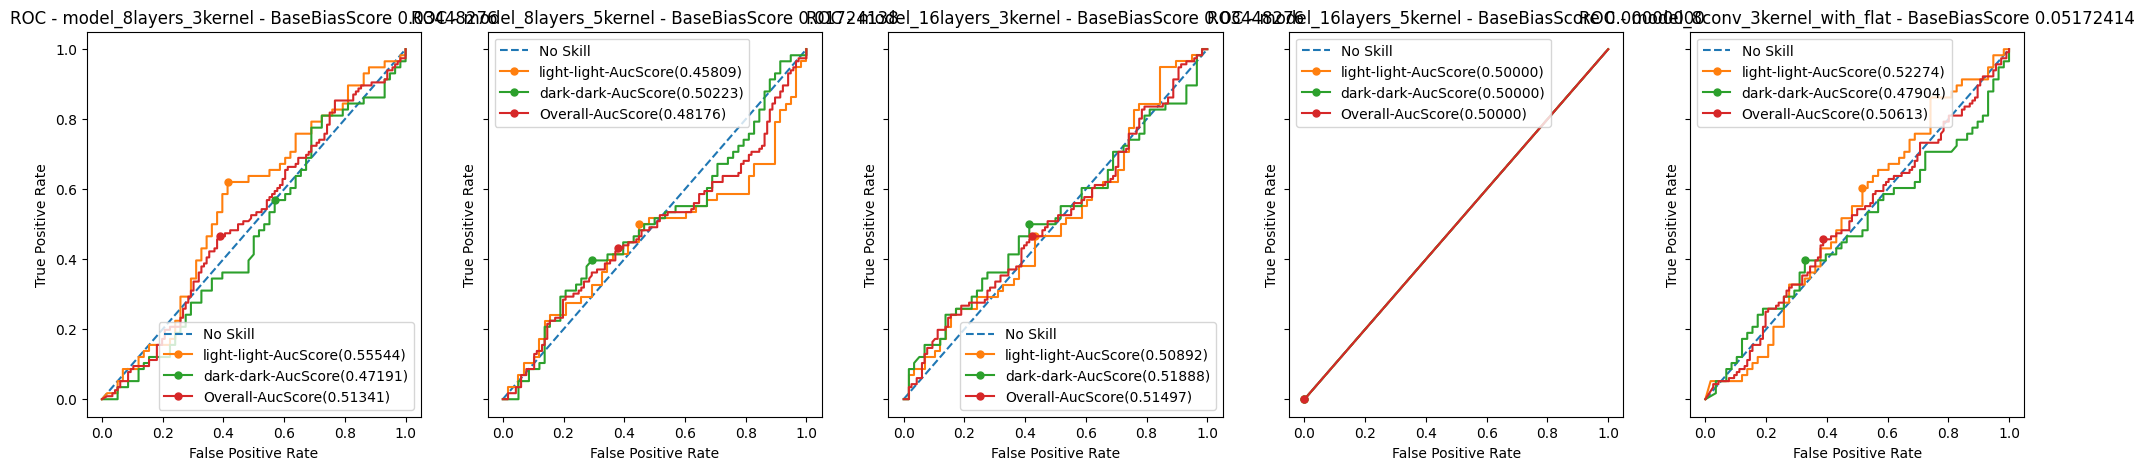

In [146]:
PredictionPlotKit.plot_multiple_roc(
    [
        model_8layers_3kernel_result,
        model_8layers_5kernel_result,
        model_16layers_3kernel_result,
        model_16layers_5kernel_result,
        model_8layers_3kernel_wit_flat_result
    ]
)